## NLP Homework 1 - Hyperparameter tuning part

### IMDB Movie Review Sentiment Analysis

The models will be based on 4-gram model. 

In [1]:
import random
import spacy
import string
import os
import pickle as pkl

In [2]:
train_data_tokens = pkl.load(open("train_data_tokens_3gram.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_3gram.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens_3gram.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_3gram.p", "rb"))

In [15]:
train_label = pkl.load(open("train_label.p", "rb"))
val_label = pkl.load(open("val_label.p", "rb"))
test_label = pkl.load(open("test_label.p", "rb"))

Test different vocabulary size in the training set. 

In [3]:
from collections import Counter
token_counter = Counter(all_train_tokens)

In [4]:
len(token_counter)

4326527

### Test vocabulary size
Since there are 4,326,527 total vocabularies in the counter, 10,000 vocabulary size in the baseline model is too low. Try different sizes. 

In [22]:
try_vocab_size = [25000, 50000, 100000]

In [6]:
def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data


In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [19]:
PAD_IDX = 0
UNK_IDX = 1
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32
learning_rate = 0.01
num_epochs = 10
emb_dim = 100 # bigger is better, 200, 500...
criterion = torch.nn.CrossEntropyLoss()  

In [23]:
for size in try_vocab_size:
    # building vocabulary and convert to indices
    max_vocab_size = size
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)
    
    # create dataloader
    train_dataset = NewsGroupDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_label)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    # run models
    model = BagOfWords(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 300 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    print('Vocab Size: {}, Validation Acc: {}'.format( 
                       size, test_model(val_loader, model)))

Epoch: [1/10], Step: [301/625], Validation Acc: 85.2
Epoch: [1/10], Step: [601/625], Validation Acc: 86.32
Epoch: [2/10], Step: [301/625], Validation Acc: 86.38
Epoch: [2/10], Step: [601/625], Validation Acc: 86.08
Epoch: [3/10], Step: [301/625], Validation Acc: 85.14
Epoch: [3/10], Step: [601/625], Validation Acc: 84.98
Epoch: [4/10], Step: [301/625], Validation Acc: 85.46
Epoch: [4/10], Step: [601/625], Validation Acc: 82.64
Epoch: [5/10], Step: [301/625], Validation Acc: 84.88
Epoch: [5/10], Step: [601/625], Validation Acc: 84.0
Epoch: [6/10], Step: [301/625], Validation Acc: 83.9
Epoch: [6/10], Step: [601/625], Validation Acc: 83.78
Epoch: [7/10], Step: [301/625], Validation Acc: 83.64
Epoch: [7/10], Step: [601/625], Validation Acc: 84.08
Epoch: [8/10], Step: [301/625], Validation Acc: 84.08
Epoch: [8/10], Step: [601/625], Validation Acc: 83.62
Epoch: [9/10], Step: [301/625], Validation Acc: 83.7
Epoch: [9/10], Step: [601/625], Validation Acc: 83.58
Epoch: [10/10], Step: [301/625],

### Test maximum sentence length

In [29]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 50000
BATCH_SIZE = 32
learning_rate = 0.01
num_epochs = 10
emb_dim = 100 # bigger is better, 200, 500...
criterion = torch.nn.CrossEntropyLoss()  

In [30]:
MAX_SENTENCE_LENGTH = [300, 400, 500]

In [31]:
for sentence_length in MAX_SENTENCE_LENGTH:
    MAX_SENTENCE_LENGTH = sentence_length
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)
    
    # create dataloader
    train_dataset = NewsGroupDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_label)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    # run models
    model = BagOfWords(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 300 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    print('Sentence length: {}, Validation Acc: {}'.format( 
                       sentence_length, test_model(val_loader, model)))

Epoch: [1/10], Step: [301/625], Validation Acc: 86.06
Epoch: [1/10], Step: [601/625], Validation Acc: 88.62
Epoch: [2/10], Step: [301/625], Validation Acc: 88.28
Epoch: [2/10], Step: [601/625], Validation Acc: 88.74
Epoch: [3/10], Step: [301/625], Validation Acc: 88.18
Epoch: [3/10], Step: [601/625], Validation Acc: 88.48
Epoch: [4/10], Step: [301/625], Validation Acc: 88.22
Epoch: [4/10], Step: [601/625], Validation Acc: 88.1
Epoch: [5/10], Step: [301/625], Validation Acc: 88.12
Epoch: [5/10], Step: [601/625], Validation Acc: 88.06
Epoch: [6/10], Step: [301/625], Validation Acc: 88.12
Epoch: [6/10], Step: [601/625], Validation Acc: 88.16
Epoch: [7/10], Step: [301/625], Validation Acc: 88.14
Epoch: [7/10], Step: [601/625], Validation Acc: 88.14
Epoch: [8/10], Step: [301/625], Validation Acc: 88.16
Epoch: [8/10], Step: [601/625], Validation Acc: 88.1
Epoch: [9/10], Step: [301/625], Validation Acc: 88.2
Epoch: [9/10], Step: [601/625], Validation Acc: 88.14
Epoch: [10/10], Step: [301/625]

In [32]:
MAX_SENTENCE_LENGTH = [600, 700, 800]

In [33]:
for sentence_length in MAX_SENTENCE_LENGTH:
    MAX_SENTENCE_LENGTH = sentence_length
    token2id, id2token = build_vocab(all_train_tokens)
    train_data_indices = token2index_dataset(train_data_tokens)
    val_data_indices = token2index_dataset(val_data_tokens)
    test_data_indices = token2index_dataset(test_data_tokens)
    
    # create dataloader
    train_dataset = NewsGroupDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_label)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    # run models
    model = BagOfWords(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 300 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    print('Sentence length: {}, Validation Acc: {}'.format( 
                       sentence_length, test_model(val_loader, model)))

Epoch: [1/10], Step: [301/625], Validation Acc: 88.36
Epoch: [1/10], Step: [601/625], Validation Acc: 90.18
Epoch: [2/10], Step: [301/625], Validation Acc: 90.44
Epoch: [2/10], Step: [601/625], Validation Acc: 89.9
Epoch: [3/10], Step: [301/625], Validation Acc: 90.52
Epoch: [3/10], Step: [601/625], Validation Acc: 89.76
Epoch: [4/10], Step: [301/625], Validation Acc: 90.16
Epoch: [4/10], Step: [601/625], Validation Acc: 90.2
Epoch: [5/10], Step: [301/625], Validation Acc: 89.74
Epoch: [5/10], Step: [601/625], Validation Acc: 90.24
Epoch: [6/10], Step: [301/625], Validation Acc: 90.36
Epoch: [6/10], Step: [601/625], Validation Acc: 90.3
Epoch: [7/10], Step: [301/625], Validation Acc: 90.24
Epoch: [7/10], Step: [601/625], Validation Acc: 90.2
Epoch: [8/10], Step: [301/625], Validation Acc: 90.12
Epoch: [8/10], Step: [601/625], Validation Acc: 90.2
Epoch: [9/10], Step: [301/625], Validation Acc: 90.34
Epoch: [9/10], Step: [601/625], Validation Acc: 90.2
Epoch: [10/10], Step: [301/625], V

### Test of embedding size

In [34]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 50000
MAX_SENTENCE_LENGTH = 800
BATCH_SIZE = 32
learning_rate = 0.01
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss() 

In [35]:
try_emb_dim = [200, 500, 1000]
token2id, id2token = build_vocab(all_train_tokens)
train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
    
# create dataloader
train_dataset = NewsGroupDataset(train_data_indices, train_label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=BATCH_SIZE,
                                            collate_fn=newsgroup_collate_func,
                                            shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                            batch_size=BATCH_SIZE,
                                            collate_fn=newsgroup_collate_func,
                                            shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=BATCH_SIZE,
                                            collate_fn=newsgroup_collate_func,
                                            shuffle=False)

In [36]:
for emb_dim in try_emb_dim:
    model = BagOfWords(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 300 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    print('Embedding dimension: {}, Validation Acc: {}'.format( 
                       emb_dim, test_model(val_loader, model)))

Epoch: [1/10], Step: [301/625], Validation Acc: 88.92
Epoch: [1/10], Step: [601/625], Validation Acc: 90.76
Epoch: [2/10], Step: [301/625], Validation Acc: 90.96
Epoch: [2/10], Step: [601/625], Validation Acc: 90.22
Epoch: [3/10], Step: [301/625], Validation Acc: 90.46
Epoch: [3/10], Step: [601/625], Validation Acc: 90.6
Epoch: [4/10], Step: [301/625], Validation Acc: 90.46
Epoch: [4/10], Step: [601/625], Validation Acc: 90.56
Epoch: [5/10], Step: [301/625], Validation Acc: 90.52
Epoch: [5/10], Step: [601/625], Validation Acc: 90.32
Epoch: [6/10], Step: [301/625], Validation Acc: 90.6
Epoch: [6/10], Step: [601/625], Validation Acc: 90.54
Epoch: [7/10], Step: [301/625], Validation Acc: 90.54
Epoch: [7/10], Step: [601/625], Validation Acc: 90.66
Epoch: [8/10], Step: [301/625], Validation Acc: 90.66
Epoch: [8/10], Step: [601/625], Validation Acc: 90.7
Epoch: [9/10], Step: [301/625], Validation Acc: 90.62
Epoch: [9/10], Step: [601/625], Validation Acc: 90.62
Epoch: [10/10], Step: [301/625]

### Test different optimizer

In [37]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 50000
MAX_SENTENCE_LENGTH = 800
emb_dim = 200
BATCH_SIZE = 32
learning_rate = 0.01
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss() 

In [38]:
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 300 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    print('Optimizer: SGD, Validation Acc: {}'.format( 
                       test_model(val_loader, model)))

Epoch: [1/10], Step: [301/625], Validation Acc: 52.2
Epoch: [1/10], Step: [601/625], Validation Acc: 54.36
Optimizer: SGD, Validation Acc: 56.8
Epoch: [2/10], Step: [301/625], Validation Acc: 51.82
Epoch: [2/10], Step: [601/625], Validation Acc: 60.66
Optimizer: SGD, Validation Acc: 62.24
Epoch: [3/10], Step: [301/625], Validation Acc: 54.06
Epoch: [3/10], Step: [601/625], Validation Acc: 61.54
Optimizer: SGD, Validation Acc: 60.68
Epoch: [4/10], Step: [301/625], Validation Acc: 53.54
Epoch: [4/10], Step: [601/625], Validation Acc: 62.2
Optimizer: SGD, Validation Acc: 52.96
Epoch: [5/10], Step: [301/625], Validation Acc: 60.04
Epoch: [5/10], Step: [601/625], Validation Acc: 56.56
Optimizer: SGD, Validation Acc: 63.14
Epoch: [6/10], Step: [301/625], Validation Acc: 62.14
Epoch: [6/10], Step: [601/625], Validation Acc: 62.4
Optimizer: SGD, Validation Acc: 52.14
Epoch: [7/10], Step: [301/625], Validation Acc: 62.94
Epoch: [7/10], Step: [601/625], Validation Acc: 60.42
Optimizer: SGD, Vali

### Test of learning rate

In [40]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 50000
MAX_SENTENCE_LENGTH = 800
emb_dim = 200
BATCH_SIZE = 32
learning_rate = 0.01
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
try_learning_rate = [0.0001, 0.001, 0.005, 0.01, 0.05]

In [42]:
for learning_rate in try_learning_rate:
    model = BagOfWords(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 300 iterations
            if i > 0 and i % 300 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    
    print('Learning rate: {}, Validation Acc: {}'.format( 
                       learning_rate, test_model(val_loader, model)))

Epoch: [1/10], Step: [301/625], Validation Acc: 50.02
Epoch: [1/10], Step: [601/625], Validation Acc: 51.52
Epoch: [2/10], Step: [301/625], Validation Acc: 62.82
Epoch: [2/10], Step: [601/625], Validation Acc: 58.24
Epoch: [3/10], Step: [301/625], Validation Acc: 62.28
Epoch: [3/10], Step: [601/625], Validation Acc: 59.72
Epoch: [4/10], Step: [301/625], Validation Acc: 74.72
Epoch: [4/10], Step: [601/625], Validation Acc: 59.68
Epoch: [5/10], Step: [301/625], Validation Acc: 63.94
Epoch: [5/10], Step: [601/625], Validation Acc: 77.16
Epoch: [6/10], Step: [301/625], Validation Acc: 72.0
Epoch: [6/10], Step: [601/625], Validation Acc: 76.68
Epoch: [7/10], Step: [301/625], Validation Acc: 78.76
Epoch: [7/10], Step: [601/625], Validation Acc: 79.2
Epoch: [8/10], Step: [301/625], Validation Acc: 76.96
Epoch: [8/10], Step: [601/625], Validation Acc: 80.24
Epoch: [9/10], Step: [301/625], Validation Acc: 79.88
Epoch: [9/10], Step: [601/625], Validation Acc: 80.1
Epoch: [10/10], Step: [301/625]

Run anealing learning rate

In [57]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 50000
MAX_SENTENCE_LENGTH = 800
emb_dim = 200
BATCH_SIZE = 32
criterion = torch.nn.CrossEntropyLoss()
model = BagOfWords(len(id2token), emb_dim)

Add regularization

In [58]:
num_epochs = 30
learning_rate = 0.005
train_accuracy_reg = []
val_accuracy_reg = []
for epoch in range(num_epochs):
    if epoch > 0 and epoch % 3 == 0:
        learning_rate = learning_rate / 2
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 300 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    trainacc = test_model(train_loader, model)
    valacc = test_model(val_loader, model)
    train_accuracy.append(trainacc)
    val_accuracy.append(valacc)
    print('Learning rate: {}, Validation Acc: {}'.format( 
                       learning_rate, valacc))

Epoch: [1/30], Step: [301/625], Validation Acc: 58.06
Epoch: [1/30], Step: [601/625], Validation Acc: 73.62
Learning rate: 0.005, Validation Acc: 76.5
Epoch: [2/30], Step: [301/625], Validation Acc: 81.46
Epoch: [2/30], Step: [601/625], Validation Acc: 81.74
Learning rate: 0.005, Validation Acc: 83.78
Epoch: [3/30], Step: [301/625], Validation Acc: 84.52
Epoch: [3/30], Step: [601/625], Validation Acc: 85.1
Learning rate: 0.005, Validation Acc: 84.1
Epoch: [4/30], Step: [301/625], Validation Acc: 85.12
Epoch: [4/30], Step: [601/625], Validation Acc: 85.7
Learning rate: 0.0025, Validation Acc: 85.96
Epoch: [5/30], Step: [301/625], Validation Acc: 86.1
Epoch: [5/30], Step: [601/625], Validation Acc: 86.24
Learning rate: 0.0025, Validation Acc: 86.52
Epoch: [6/30], Step: [301/625], Validation Acc: 85.76
Epoch: [6/30], Step: [601/625], Validation Acc: 86.46
Learning rate: 0.0025, Validation Acc: 86.54
Epoch: [7/30], Step: [301/625], Validation Acc: 85.64
Epoch: [7/30], Step: [601/625], Vali

In [52]:
test_model(train_loader, model)

100.0

without regularization

In [65]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 50000
MAX_SENTENCE_LENGTH = 800
emb_dim = 200
BATCH_SIZE = 32
criterion = torch.nn.CrossEntropyLoss()
model = BagOfWords(len(id2token), emb_dim)

In [66]:
num_epochs = 30
learning_rate = 0.005
train_accuracy_noreg = []
val_accuracy_noreg = []
val_accuracy_old = 0
best_performing_model = model
for epoch in range(num_epochs):
    if epoch > 0 and epoch % 3 == 0:
        learning_rate = learning_rate / 2
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 300 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            if val_acc > val_accuracy_old:
                best_performing_model = model
                val_accuracy_old = val_acc
    trainacc = test_model(train_loader, model)
    valacc = test_model(val_loader, model)
    train_accuracy.append(trainacc)
    val_accuracy.append(valacc)
    print('Learning rate: {}, Validation Acc: {}'.format( 
                       learning_rate, valacc))

Epoch: [1/30], Step: [101/625], Validation Acc: 74.72
Epoch: [1/30], Step: [201/625], Validation Acc: 83.18
Epoch: [1/30], Step: [301/625], Validation Acc: 86.3
Epoch: [1/30], Step: [401/625], Validation Acc: 82.74
Epoch: [1/30], Step: [501/625], Validation Acc: 86.96
Epoch: [1/30], Step: [601/625], Validation Acc: 89.62
Learning rate: 0.005, Validation Acc: 89.7
Epoch: [2/30], Step: [101/625], Validation Acc: 90.08
Epoch: [2/30], Step: [201/625], Validation Acc: 90.18
Epoch: [2/30], Step: [301/625], Validation Acc: 90.04
Epoch: [2/30], Step: [401/625], Validation Acc: 88.28
Epoch: [2/30], Step: [501/625], Validation Acc: 89.84
Epoch: [2/30], Step: [601/625], Validation Acc: 90.44
Learning rate: 0.005, Validation Acc: 90.78
Epoch: [3/30], Step: [101/625], Validation Acc: 90.82
Epoch: [3/30], Step: [201/625], Validation Acc: 90.62
Epoch: [3/30], Step: [301/625], Validation Acc: 90.76
Epoch: [3/30], Step: [401/625], Validation Acc: 90.8
Epoch: [3/30], Step: [501/625], Validation Acc: 90.

Epoch: [23/30], Step: [101/625], Validation Acc: 90.58
Epoch: [23/30], Step: [201/625], Validation Acc: 90.54
Epoch: [23/30], Step: [301/625], Validation Acc: 90.54
Epoch: [23/30], Step: [401/625], Validation Acc: 90.58
Epoch: [23/30], Step: [501/625], Validation Acc: 90.48
Epoch: [23/30], Step: [601/625], Validation Acc: 90.56
Learning rate: 3.90625e-05, Validation Acc: 90.64
Epoch: [24/30], Step: [101/625], Validation Acc: 90.52
Epoch: [24/30], Step: [201/625], Validation Acc: 90.52
Epoch: [24/30], Step: [301/625], Validation Acc: 90.58
Epoch: [24/30], Step: [401/625], Validation Acc: 90.52
Epoch: [24/30], Step: [501/625], Validation Acc: 90.52
Epoch: [24/30], Step: [601/625], Validation Acc: 90.54
Learning rate: 3.90625e-05, Validation Acc: 90.56
Epoch: [25/30], Step: [101/625], Validation Acc: 90.56
Epoch: [25/30], Step: [201/625], Validation Acc: 90.54
Epoch: [25/30], Step: [301/625], Validation Acc: 90.54
Epoch: [25/30], Step: [401/625], Validation Acc: 90.56
Epoch: [25/30], Step

In [68]:
test_model(val_loader, best_performing_model)

90.54

In [83]:
val_accuracy1 = val_accuracy[0:30]
train_accuracy1 = train_accuracy[0:30]

Plot

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

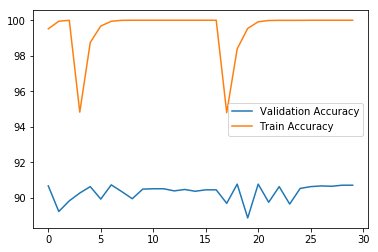

In [84]:
plt.plot(range(30), val_accuracy1, label="Validation Accuracy")
plt.plot(range(30), train_accuracy1, label="Train Accuracy")
plt.legend(loc = 'best')
plt.show()

In [85]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 50000
MAX_SENTENCE_LENGTH = 800
emb_dim = 200
BATCH_SIZE = 32
criterion = torch.nn.CrossEntropyLoss()
model = BagOfWords(len(id2token), emb_dim)

In [86]:
num_epochs = 15
learning_rate = 0.005
train_accuracy_noreg2 = []
val_accuracy_noreg2 = []
val_accuracy_step2 = []
highest_val_acc = 0
best_performing_model2 = model
for epoch in range(num_epochs):
    if epoch > 0 and epoch % 3 == 0:
        learning_rate = learning_rate / 2
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            val_accuracy_step2.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            highest_val_acc = max(val_accuracy_step2)
            if val_acc > highest_val_acc:
                best_performing_model2 = model
                
    trainacc = test_model(train_loader, model)
    valacc = test_model(val_loader, model)
    train_accuracy_noreg2.append(trainacc)
    val_accuracy_noreg2.append(valacc)
    print('Learning rate: {}, Validation Acc: {}'.format( 
                       learning_rate, valacc))

Epoch: [1/15], Step: [101/625], Validation Acc: 80.3
Epoch: [1/15], Step: [201/625], Validation Acc: 84.2
Epoch: [1/15], Step: [301/625], Validation Acc: 85.54
Epoch: [1/15], Step: [401/625], Validation Acc: 84.94
Epoch: [1/15], Step: [501/625], Validation Acc: 88.56
Epoch: [1/15], Step: [601/625], Validation Acc: 89.56
Learning rate: 0.005, Validation Acc: 88.4
Epoch: [2/15], Step: [101/625], Validation Acc: 90.54
Epoch: [2/15], Step: [201/625], Validation Acc: 89.94
Epoch: [2/15], Step: [301/625], Validation Acc: 90.58
Epoch: [2/15], Step: [401/625], Validation Acc: 90.14
Epoch: [2/15], Step: [501/625], Validation Acc: 90.6
Epoch: [2/15], Step: [601/625], Validation Acc: 90.58
Learning rate: 0.005, Validation Acc: 90.44
Epoch: [3/15], Step: [101/625], Validation Acc: 91.28
Epoch: [3/15], Step: [201/625], Validation Acc: 90.82
Epoch: [3/15], Step: [301/625], Validation Acc: 89.28
Epoch: [3/15], Step: [401/625], Validation Acc: 90.58
Epoch: [3/15], Step: [501/625], Validation Acc: 90.4

In [87]:
highest_val_acc

91.28

In [88]:
test_model(val_loader, model)

90.28

In [89]:
test_model(val_loader, best_performing_model2)

90.28

In [82]:
val_accuracy_noreg2

[]

### Best model

In [90]:
PAD_IDX = 0
UNK_IDX = 1
max_vocab_size = 50000
MAX_SENTENCE_LENGTH = 800
emb_dim = 200
BATCH_SIZE = 32
criterion = torch.nn.CrossEntropyLoss()
model = BagOfWords(len(id2token), emb_dim)
num_epochs = 10
learning_rate = 0.001
train_accuracy_final = []
val_accuracy_final = []
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 300 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                        epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    trainacc = test_model(train_loader, model)
    valacc = test_model(val_loader, model)
    train_accuracy_final.append(trainacc)
    val_accuracy_final.append(valacc)
    print('Learning rate: {}, Validation Acc: {}'.format( 
                       learning_rate, valacc))

Epoch: [1/10], Step: [301/625], Validation Acc: 70.82
Epoch: [1/10], Step: [601/625], Validation Acc: 73.84
Learning rate: 0.001, Validation Acc: 79.04
Epoch: [2/10], Step: [301/625], Validation Acc: 83.58
Epoch: [2/10], Step: [601/625], Validation Acc: 86.98
Learning rate: 0.001, Validation Acc: 87.28
Epoch: [3/10], Step: [301/625], Validation Acc: 88.18
Epoch: [3/10], Step: [601/625], Validation Acc: 88.62
Learning rate: 0.001, Validation Acc: 88.26
Epoch: [4/10], Step: [301/625], Validation Acc: 89.38
Epoch: [4/10], Step: [601/625], Validation Acc: 89.16
Learning rate: 0.001, Validation Acc: 89.44
Epoch: [5/10], Step: [301/625], Validation Acc: 89.6
Epoch: [5/10], Step: [601/625], Validation Acc: 90.0
Learning rate: 0.001, Validation Acc: 90.12
Epoch: [6/10], Step: [301/625], Validation Acc: 90.68
Epoch: [6/10], Step: [601/625], Validation Acc: 90.76
Learning rate: 0.001, Validation Acc: 90.46
Epoch: [7/10], Step: [301/625], Validation Acc: 90.5
Epoch: [7/10], Step: [601/625], Valid

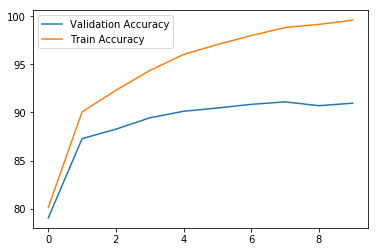

In [92]:
plt.plot(range(10), val_accuracy_final, label="Validation Accuracy")
plt.plot(range(10), train_accuracy_final, label="Train Accuracy")
plt.legend(loc = 'best')
plt.show()

In [93]:
test_model(test_loader, model)

90.008

### Model prediction interpretation

In [ ]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)